In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [0]:
df = pd.read_csv(path/'texts.csv')

In [6]:
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [8]:
df['text'][2]

'Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt like I was watching a junior high video presentation. Have the directors, producers, etc. ever even seen a movie before? Halestorm is getting worse and worse with every new entry. The concept for this movie sounded so funny. How could you go wrong with Gary Coleman and a handful of somewhat legitimate actors. But trust me when I say this, things went wrong, VERY WRONG.'

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [0]:
data_lm.save()

In [0]:
data = load_data(path)

In [15]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


In [16]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [17]:
data.train_ds[0][0]

Text xxbos xxmaj this is a wonderfully written and well acted psychological drama . xxmaj it is not really a horror flick so those looking for something like xxmaj the xxmaj ring or xxmaj the xxmaj grudge will be disappointed . xxmaj what really surprised me about this film was the intelligence and subtle attention to detail in the plot and the effort made to be xxunk consistent . i also appreciated the absence of xxmaj dr. xxmaj phil psychobabble or xxmaj new xxmaj age xxunk . xxmaj rather than xxunk an agenda , the filmmakers just told the story , told it well and let the viewer think about it . xxmaj the sparse dreamscapes were reminiscent of xxmaj xxunk paintings and amazingly effective . 
 
  a great example of how to make a good film on a small budget , without big studios , star actors , big - name directors ( this was far better than many of xxmaj hitchcock 's films ) , special effects or " clever " plot twists .

In [18]:
data.train_ds[0][0].data[:10]

array([   2,    5,   21,   16,   13, 1557,  420,   12,   89,  939])

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [0]:
bs=48

In [21]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [22]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

In [0]:
data_lm = (TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [25]:
data_lm.show_batch()

idx,text
0,"the night from a xxmaj mariah xxmaj carey nightmare ! ;) \n \n xxmaj so - i watched it , but i watched most of it in fast forward . xxmaj you get the picture that most of the cast are mean people who are going to ' get it in bad ways ' as soon as they are introduced . \n \n xxmaj this is a real"
1,"this movie affected the audience that much . \n \n i consider this to be equal to xxmaj citizen xxmaj kane as far as quality movies are concerned . xxmaj this is n't light entertainment . xxbos xxmaj in this hoped for "" revival "" of the xxmaj blaxploitation genre , you have the superstars of xxmaj black ' 70s cinema : xxmaj jim xxmaj brown ( always with"
2,". xxmaj it 's just your basic sports movie ( although there is debate about whether cheering is a sport . ) xxmaj however , the aspect that really brings the movie down is the seriousness that is laid on extra thick in nearly every scene . xxmaj for example , when trying to convince a skeptical newcomer to join the team , xxmaj torrance says with a cheesy grin"
3,"keep in line with reality when it comes to women seeking revenge over imagined slights . \n \n xxmaj now men on the other hand should be thinking about getting even since we have been treated horribly by women for years . xxmaj they should make a film called "" xxmaj tom and xxmaj jack "" where men go around breaking the law and acting crazy . xxmaj the"
4,"not only adolescents , but anyone . i have personally heard from nine - to - xxunk who were inspired by this movie to change the situations of their jobs , careers , relationships for the better . i first saw this movie when i was 13 , and immediately stamped , crowned and elevated this movie as my all - time favorite . xxmaj now that i am 18"


In [26]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [27]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


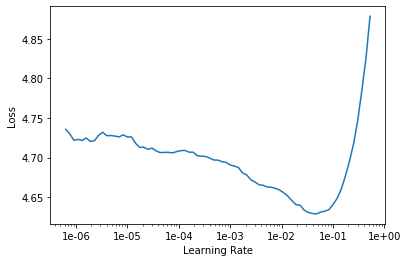

In [28]:
learn.recorder.plot(skip_end=15)

In [29]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.199838,4.021939,0.295500,46:44


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.788058,3.733792,0.329100,52:05


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned')

In [0]:
TEXT = "This movie was an absolute waste of time beacause"
N_WORDS = 40
N_SENTENCES = 3

In [38]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was an absolute waste of time beacause my friends and i watched it just to save your money . The acting was horrible . You could build a little suspense and some very cute scenes . If you are a fan of the original
This movie was an absolute waste of time beacause by the some actors who are filmmakers who were often given little to work with . For example , the husband played by Lee Van Cleef , who is terribly annoying , was pretty boring .
This movie was an absolute waste of time beacause . The script was written by David Mamet ( Director ) , John Carpenter ( The Great Closer ) , Paul Thomas Anderson ( Plan 9 from


In [0]:
learn.save_encoder('fine_tuned_enc')

<h2>Classifier for movie reviews</h2>

In [0]:
path = untar_data(URLs.IMDB)

In [50]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             .split_by_folder(valid='test')
             .label_from_folder(classes=['neg', 'pos'])
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [52]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos * ! ! - xxup spoilers - ! ! * \n \n xxmaj before i begin this , let me say that i have had both the advantages of seeing this movie on the big screen and of having seen the "" xxmaj authorized xxmaj version "" of this movie , remade by xxmaj stephen xxmaj king , himself , in 1997 . \n \n xxmaj both",pos
"xxbos i thought that xxup rotj was clearly the best out of the three xxmaj star xxmaj wars movies . i find it surprising that xxup rotj is considered the weakest installment in the xxmaj trilogy by many who have voted . xxmaj to me it seemed like xxup rotj was the best because it had the most profound plot , the most suspense , surprises , most xxunk the",pos
"xxbos xxmaj jim xxmaj carrey is back to much the same role that he played in xxmaj the xxmaj mask , a timid guy who is trying to get ahead in the world but who seems to be plagued with bad luck . xxmaj even when he tries to help a homeless guy from being harassed by a bunch of hoodlums ( and of course they have to be xxmaj",pos
"xxbos xxmaj chris xxmaj rock deserves better than he gives himself in "" xxmaj down xxmaj to xxmaj earth . "" xxmaj as directed by brothers xxmaj chris & xxmaj paul xxmaj weitz of "" xxmaj american xxmaj pie "" fame , this uninspired remake of xxmaj warren xxmaj beatty 's 1978 fantasy "" xxmaj heaven xxmaj can xxmaj wait , "" itself a rehash of 1941 's "" xxmaj",neg


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [54]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


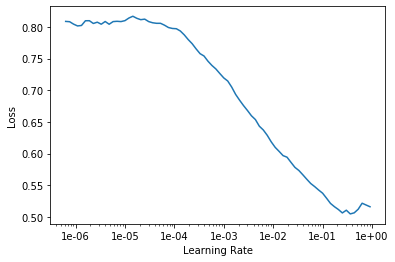

In [46]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(1, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.289168,0.225061,0.908200,04:53


In [0]:
learn.save('first')

In [0]:
learn.load('first')

In [59]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.240493,0.182677,0.930840,05:36


In [0]:
learn.save('second')

In [0]:
learn.load('second')

In [62]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.203206,0.158264,0.939600,07:26


In [0]:
learn.save('third')

In [0]:
learn.load('third')

In [65]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.162605,0.157887,0.940560,09:53
1,0.135893,0.159608,0.941360,08:52


In [66]:
learn.predict("My son saw this movie with my husband. He is 13. They are both big movie buffs and my son is a very mature movie goer. We do restrict him on some movies but this one we allowed. Both my husband and him thought it was excellent! I think this movie is good for mature teenagers who are watching it with an adult. By contrast, I also have an 11 year old who is not ready for this and did not see it. It's important to know your kid.")

(Category pos, tensor(1), tensor([0.0231, 0.9769]))